# Detección de Fraude con Árbol de Decisión y Matriz de Confusión


Este notebook genera un conjunto de datos simulado de transacciones con tarjetas de crédito, marcando aquellas que son fraude. Luego, se realiza un balanceo de clases, se entrena un árbol de decisión y se evalúa el modelo con una matriz de confusión y el accuracy.


# Diccionario de Datos - Dataset de Transacciones de Tarjeta de Crédito

Este dataset simulado contiene información sobre transacciones con tarjetas de crédito, incluyendo indicadores relevantes para la detección de fraude.

| Columna                     | Tipo       | Descripción                                                                 |
|----------------------------|------------|-----------------------------------------------------------------------------|
| `amount`                   | `float`    | Monto en dólares de la transacción. Simulado con una distribución exponencial para reflejar que la mayoría de transacciones son pequeñas. |
| `time_since_last_transaction` | `float` | Tiempo (en minutos) desde la última transacción del mismo usuario. Valores altos pueden indicar comportamiento inusual. |
| `is_foreign_transaction`   | `int` (0/1)| Indica si la transacción se realizó fuera del país (`1` = sí, `0` = no). |
| `is_high_risk_country`     | `int` (0/1)| Indica si la transacción proviene de un país clasificado como de alto riesgo (`1` = sí, `0` = no). |
| `has_chip`                 | `int` (0/1)| Indica si la tarjeta utilizada tenía chip (`1`) o fue deslizada (`0`). Las tarjetas con chip son más seguras. |
| `merchant_risk_score`      | `float`    | Puntaje entre 0 y 1 que indica qué tan riesgoso es el comercio donde se hizo la compra. |
| `is_fraud`                 | `int` (0/1)| Etiqueta de la clase objetivo: indica si la transacción fue fraudulenta (`1`) o legítima (`0`). |


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [3]:
# 1. Generar datos dummy
np.random.seed(42)
n_samples = 1000

In [4]:
amount = np.random.exponential(scale=100, size=n_samples)
time_since_last_transaction = np.random.exponential(scale=30, size=n_samples)
is_foreign_transaction = np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05])
is_high_risk_country = np.random.choice([0, 1], size=n_samples, p=[0.97, 0.03])
has_chip = np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1])
merchant_risk_score = np.random.uniform(0, 1, size=n_samples)
fraud = np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05])

In [5]:
df = pd.DataFrame({
    'amount': amount,
    'time_since_last_transaction': time_since_last_transaction,
    'is_foreign_transaction': is_foreign_transaction,
    'is_high_risk_country': is_high_risk_country,
    'has_chip': has_chip,
    'merchant_risk_score': merchant_risk_score,
    'is_fraud': fraud
})

In [6]:
df.head()

,amount,time_since_last_transaction,is_foreign_transaction,is_high_risk_country,has_chip,merchant_risk_score,is_fraud
0,46.926809,6.141908,0,0,0,0.393636,0
1,301.012143,23.420095,0,0,0,0.473436,0
2,131.674569,61.894254,0,0,0,0.854547,0
3,91.294255,39.528233,0,0,0,0.340004,0
4,16.962487,49.283815,0,0,0,0.869650,0


In [7]:
df['is_fraud'].value_counts()

is_fraud
0    956
1     44
Name: count, dtype: int64

# ¿Cómo funciona `resample()` para balancear clases en un dataset?

El método `resample()` de `sklearn.utils` se utiliza para generar una nueva muestra de datos, siendo una herramienta muy útil cuando se desea balancear clases desbalanceadas en problemas de clasificación.

---

## Ejemplo de uso

```python
from sklearn.utils import resample

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)
```

Esta instrucción realiza un **sobremuestreo** (upsampling) de la clase minoritaria (`df_minority`) para que tenga la misma cantidad de registros que la clase mayoritaria (`df_majority`).

---

## Descripción de los parámetros

| Parámetro                  | Descripción |
|---------------------------|-------------|
| `df_minority`             | El subconjunto del dataframe que contiene las filas de la clase minoritaria (por ejemplo, fraudes). |
| `replace=True`            | Permite la selección con reemplazo, es decir, una misma fila puede aparecer más de una vez en la nueva muestra. Esto es esencial cuando no hay suficientes ejemplos únicos para alcanzar el tamaño deseado. |
| `n_samples=len(df_majority)` | Especifica que se desea obtener el mismo número de muestras que hay en la clase mayoritaria, logrando así un balance. |
| `random_state=42`         | Fija la semilla aleatoria para garantizar que los resultados sean reproducibles. |

---

## ¿Qué hace realmente?

Supongamos el siguiente caso:
- `df_majority`: 950 registros (no fraude)
- `df_minority`: 50 registros (fraude)

El `resample()` creará una nueva muestra de `df_minority` con **950 registros**, repitiendo aleatoriamente filas del conjunto original. El resultado es un dataset balanceado, listo para entrenar modelos que no ignoren la clase minoritaria.

---

## ¿Por qué es útil?

Cuando las clases están muy desbalanceadas, los modelos tienden a favorecer la clase mayoritaria, ignorando la menor (por ejemplo, prediciendo que todo es "no fraude"). El sobremuestreo ayuda a mejorar el aprendizaje de la clase minoritaria, especialmente en contextos críticos como:

- Detección de fraude financiero
- Clasificación de correos como spam
- Diagnóstico de enfermedades poco comunes
- Reconocimiento de objetos raros en visión por computadora

Este proceso mejora la sensibilidad del modelo hacia eventos raros o críticos, ayudando a reducir los falsos negativos.


In [9]:
# 2. Balancear las clases por sobremuestreo
df_majority = df[df.is_fraud == 0]
df_minority = df[df.is_fraud == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced['is_fraud'].value_counts()

is_fraud
0    956
1    956
Name: count, dtype: int64

In [10]:
# 3. Separar variables y etiquetas
X = df_balanced.drop(columns='is_fraud')
y = df_balanced['is_fraud']

In [11]:
# 4. Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
# 5. Entrenar Árbol de Decisión
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [13]:
# 6. Matriz de Confusión y Accuracy
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

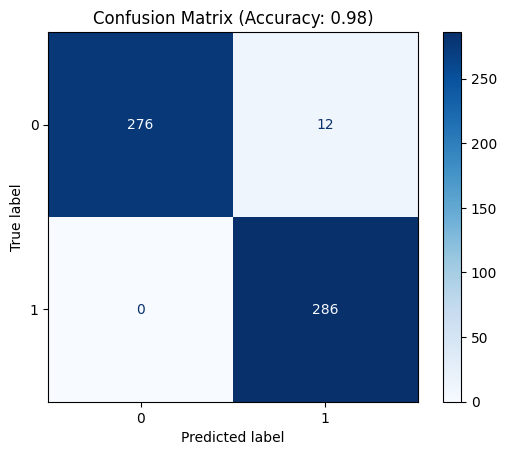

In [14]:
# Mostrar matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Accuracy: {acc:.2f})")
plt.show()